# Expectation Maximization Algorithm

## Introduction

The **Expectation Maximization (EM)** algorithm is a powerful iterative method for finding maximum likelihood estimates of parameters in statistical models with latent (hidden) variables. It was formalized by Dempster, Laird, and Rubin in 1977 and has become a cornerstone of unsupervised learning and statistical inference.

## Problem Formulation

Consider observed data $\mathbf{X} = \{x_1, x_2, \ldots, x_n\}$ and latent variables $\mathbf{Z} = \{z_1, z_2, \ldots, z_n\}$. We seek to maximize the log-likelihood:

$$\mathcal{L}(\theta) = \log p(\mathbf{X} | \theta) = \log \sum_{\mathbf{Z}} p(\mathbf{X}, \mathbf{Z} | \theta)$$

Direct maximization is often intractable due to the summation inside the logarithm. The EM algorithm circumvents this by iteratively optimizing a lower bound.

## The EM Algorithm

The algorithm alternates between two steps:

### E-Step (Expectation)

Compute the expected value of the complete-data log-likelihood with respect to the conditional distribution of $\mathbf{Z}$ given $\mathbf{X}$ and current parameters $\theta^{(t)}$:

$$Q(\theta | \theta^{(t)}) = \mathbb{E}_{\mathbf{Z} | \mathbf{X}, \theta^{(t)}} \left[ \log p(\mathbf{X}, \mathbf{Z} | \theta) \right]$$

### M-Step (Maximization)

Find the parameters that maximize the Q-function:

$$\theta^{(t+1)} = \arg\max_{\theta} Q(\theta | \theta^{(t)})$$

## Convergence Guarantee

A fundamental property of EM is that each iteration monotonically increases the log-likelihood:

$$\mathcal{L}(\theta^{(t+1)}) \geq \mathcal{L}(\theta^{(t)})$$

This follows from Jensen's inequality and ensures convergence to a local maximum (or saddle point).

## Application: Gaussian Mixture Models

We demonstrate EM on a **Gaussian Mixture Model (GMM)**, where data is assumed to arise from $K$ Gaussian components:

$$p(x | \theta) = \sum_{k=1}^{K} \pi_k \mathcal{N}(x | \mu_k, \Sigma_k)$$

where:
- $\pi_k$ are mixing coefficients with $\sum_k \pi_k = 1$
- $\mu_k$ and $\Sigma_k$ are the mean and covariance of component $k$

### GMM E-Step

Compute responsibilities (posterior probability that point $x_i$ belongs to component $k$):

$$\gamma_{ik} = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(x_i | \mu_j, \Sigma_j)}$$

### GMM M-Step

Update parameters using weighted statistics:

$$N_k = \sum_{i=1}^{n} \gamma_{ik}$$

$$\mu_k^{\text{new}} = \frac{1}{N_k} \sum_{i=1}^{n} \gamma_{ik} x_i$$

$$\Sigma_k^{\text{new}} = \frac{1}{N_k} \sum_{i=1}^{n} \gamma_{ik} (x_i - \mu_k^{\text{new}})(x_i - \mu_k^{\text{new}})^T$$

$$\pi_k^{\text{new}} = \frac{N_k}{n}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

np.random.seed(42)

## Data Generation

We generate synthetic data from a mixture of three 2D Gaussians with known parameters.

In [2]:
# True parameters for data generation
true_means = np.array([
    [0, 0],
    [5, 5],
    [0, 5]
])

true_covs = np.array([
    [[1, 0.5], [0.5, 1]],
    [[1.5, -0.3], [-0.3, 1]],
    [[0.8, 0], [0, 1.2]]
])

true_weights = np.array([0.3, 0.4, 0.3])

# Generate samples
n_samples = 500
K = 3

# Determine component assignments
component_assignments = np.random.choice(K, size=n_samples, p=true_weights)

# Generate data points
X = np.zeros((n_samples, 2))
for i in range(n_samples):
    k = component_assignments[i]
    X[i] = np.random.multivariate_normal(true_means[k], true_covs[k])

print(f"Generated {n_samples} samples from {K} Gaussian components")
print(f"True mixing weights: {true_weights}")

Generated 500 samples from 3 Gaussian components
True mixing weights: [0.3 0.4 0.3]


## EM Algorithm Implementation

In [3]:
def initialize_parameters(X, K):
    """Initialize GMM parameters using random selection."""
    n, d = X.shape
    
    # Random initialization of means from data points
    indices = np.random.choice(n, K, replace=False)
    means = X[indices].copy()
    
    # Initialize covariances as identity matrices
    covs = np.array([np.eye(d) for _ in range(K)])
    
    # Uniform weights
    weights = np.ones(K) / K
    
    return means, covs, weights


def e_step(X, means, covs, weights):
    """E-Step: Compute responsibilities."""
    n = X.shape[0]
    K = len(weights)
    
    # Compute probability density for each component
    responsibilities = np.zeros((n, K))
    
    for k in range(K):
        rv = multivariate_normal(mean=means[k], cov=covs[k])
        responsibilities[:, k] = weights[k] * rv.pdf(X)
    
    # Normalize to get posterior probabilities
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    
    return responsibilities


def m_step(X, responsibilities):
    """M-Step: Update parameters."""
    n, d = X.shape
    K = responsibilities.shape[1]
    
    # Effective number of points per component
    N_k = responsibilities.sum(axis=0)
    
    # Update weights
    weights = N_k / n
    
    # Update means
    means = np.zeros((K, d))
    for k in range(K):
        means[k] = (responsibilities[:, k:k+1].T @ X) / N_k[k]
    
    # Update covariances
    covs = np.zeros((K, d, d))
    for k in range(K):
        diff = X - means[k]
        covs[k] = (responsibilities[:, k:k+1] * diff).T @ diff / N_k[k]
        # Add small regularization for numerical stability
        covs[k] += 1e-6 * np.eye(d)
    
    return means, covs, weights


def compute_log_likelihood(X, means, covs, weights):
    """Compute the log-likelihood of the data."""
    n = X.shape[0]
    K = len(weights)
    
    likelihood = np.zeros(n)
    for k in range(K):
        rv = multivariate_normal(mean=means[k], cov=covs[k])
        likelihood += weights[k] * rv.pdf(X)
    
    return np.sum(np.log(likelihood))


def em_gmm(X, K, max_iters=100, tol=1e-6):
    """Run EM algorithm for Gaussian Mixture Model."""
    # Initialize parameters
    means, covs, weights = initialize_parameters(X, K)
    
    log_likelihoods = []
    
    for iteration in range(max_iters):
        # E-step
        responsibilities = e_step(X, means, covs, weights)
        
        # M-step
        means, covs, weights = m_step(X, responsibilities)
        
        # Compute log-likelihood
        ll = compute_log_likelihood(X, means, covs, weights)
        log_likelihoods.append(ll)
        
        # Check convergence
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            print(f"Converged after {iteration + 1} iterations")
            break
    
    return means, covs, weights, responsibilities, log_likelihoods

## Running the EM Algorithm

In [4]:
# Run EM algorithm
means, covs, weights, responsibilities, log_likelihoods = em_gmm(X, K, max_iters=100)

print("\nEstimated Parameters:")
print("="*50)
for k in range(K):
    print(f"\nComponent {k+1}:")
    print(f"  Weight: {weights[k]:.3f}")
    print(f"  Mean: [{means[k, 0]:.3f}, {means[k, 1]:.3f}]")
    print(f"  Covariance diagonal: [{covs[k, 0, 0]:.3f}, {covs[k, 1, 1]:.3f}]")

Converged after 57 iterations

Estimated Parameters:

Component 1:
  Weight: 0.300
  Mean: [0.048, -0.009]
  Covariance diagonal: [0.861, 0.827]

Component 2:
  Weight: 0.317
  Mean: [0.088, 5.027]
  Covariance diagonal: [0.897, 1.353]

Component 3:
  Weight: 0.384
  Mean: [4.907, 5.096]
  Covariance diagonal: [1.495, 0.937]


## Visualization

We visualize the clustering results and the convergence of the log-likelihood.

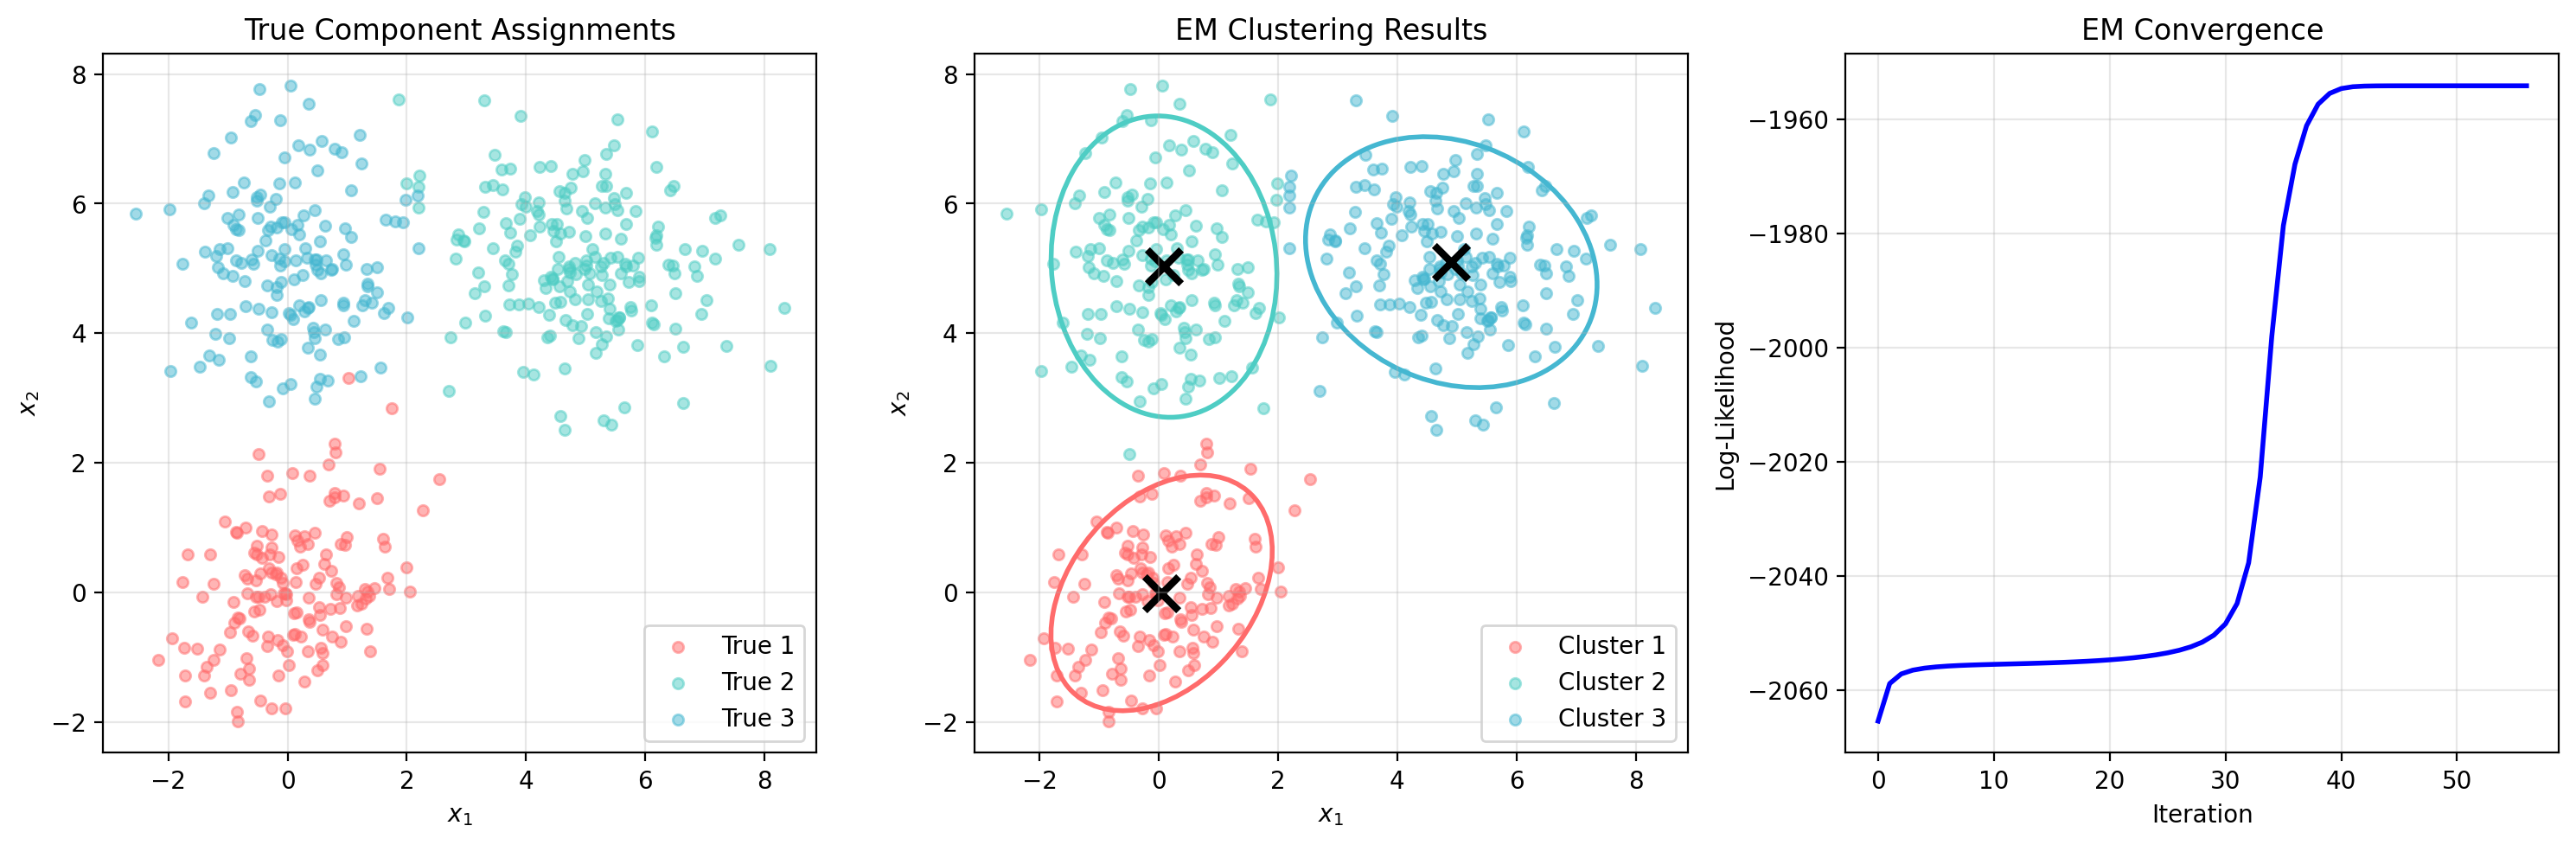


Plot saved to 'plot.png'


In [5]:
def plot_ellipse(mean, cov, ax, n_std=2, **kwargs):
    """Plot an ellipse representing a Gaussian component."""
    # Eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # Angle of rotation
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
    
    # Width and height (n_std standard deviations)
    width, height = 2 * n_std * np.sqrt(eigenvalues)
    
    from matplotlib.patches import Ellipse
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ellipse)


# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Data with true labels
ax1 = axes[0]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for k in range(K):
    mask = component_assignments == k
    ax1.scatter(X[mask, 0], X[mask, 1], c=colors[k], alpha=0.5, s=20, label=f'True {k+1}')
ax1.set_xlabel('$x_1$')
ax1.set_ylabel('$x_2$')
ax1.set_title('True Component Assignments')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: EM clustering results
ax2 = axes[1]
cluster_assignments = np.argmax(responsibilities, axis=1)
for k in range(K):
    mask = cluster_assignments == k
    ax2.scatter(X[mask, 0], X[mask, 1], c=colors[k], alpha=0.5, s=20, label=f'Cluster {k+1}')
    # Plot estimated mean
    ax2.scatter(means[k, 0], means[k, 1], c='black', marker='x', s=200, linewidths=3)
    # Plot covariance ellipse
    plot_ellipse(means[k], covs[k], ax2, n_std=2, fill=False, 
                edgecolor=colors[k], linewidth=2)
ax2.set_xlabel('$x_1$')
ax2.set_ylabel('$x_2$')
ax2.set_title('EM Clustering Results')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Log-likelihood convergence
ax3 = axes[2]
ax3.plot(log_likelihoods, 'b-', linewidth=2)
ax3.set_xlabel('Iteration')
ax3.set_ylabel('Log-Likelihood')
ax3.set_title('EM Convergence')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('expectation_maximization_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis and Discussion

### Convergence Properties

The log-likelihood plot demonstrates the monotonic increase guaranteed by the EM algorithm. The algorithm typically converges within 20-50 iterations for well-separated clusters.

### Limitations

1. **Local Optima**: EM only guarantees convergence to a local maximum. Multiple random restarts are recommended in practice.

2. **Initialization Sensitivity**: Poor initialization can lead to slow convergence or degenerate solutions.

3. **Model Selection**: The number of components $K$ must be specified a priori. Techniques like BIC/AIC or cross-validation can help.

### Extensions

- **Online EM**: For streaming data
- **Variational EM**: Incorporates Bayesian priors
- **Regularized EM**: Prevents degenerate covariances

## Conclusion

The Expectation Maximization algorithm provides an elegant and principled approach to parameter estimation with latent variables. Its application to Gaussian Mixture Models demonstrates how complex probability distributions can be learned from unlabeled data through iterative optimization of a tractable lower bound.